In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Conv2D, SeparableConv2D, Rescaling, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, Add

import matplotlib.pyplot as plt
def plotEpoch( history, metric='acc'):
    epochs = range(len(history['loss']))
    if metric=='acc':
        plt.plot(epochs, history['accuracy'], 'k', label='Training acc')
        val = history['val_accuracy']
        plt.plot(epochs, val, 'b', label='Validation acc')
        plt.axvline(x=val.index(max(val)), color='r')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()
    elif metric=='loss':
        plt.plot(epochs, history['loss'], 'k', label='Training loss')
        val = history['val_loss']
        plt.plot(epochs, val, 'b', label='Validation loss')
        plt.axvline(x=val.index(min(val)), color='r')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
#!tar -xf '/content/drive/MyDrive/Data/test/celeba00-04.tar.gz' -C '/content/drive/MyDrive/Data/test'

In [ ]:
import os
folder_path = '/content/drive/MyDrive/Data/test'

items = os.listdir(folder_path)

file_count = len([item for item in items if os.path.isfile(os.path.join(folder_path, item))])

print(f'The folder contains {file_count} files.')


The folder contains 16967 files.


In [ ]:
attributes = pd.read_csv( '/content/drive/MyDrive/Data/list_attr_celeba.csv' )
attributes.columns
LABEL = "Attractive"
attributes.head(10)[LABEL]
raw_labels = attributes[LABEL].tolist()
all_labels = [x if x == 1 else 0 for x in raw_labels]

In [ ]:
batch_size = 64
labels = all_labels[:16966]
img_size = (178,218)

In [ ]:
seed = 123

full_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Data/test',
    labels=labels,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False,
    seed=seed
)


total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_ds = full_dataset.take(train_size)
remaining_ds = full_dataset.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)
val_ds = val_ds.unbatch().batch(batch_size)
test_ds = test_ds.unbatch().batch(batch_size)

Found 16966 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_ds:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (64, 178, 218, 3)
labels batch shape: (64,)


data augmentation+ fine tunning

In [ ]:
!pip install keras-tuner
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def build_model(hp):
    conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
    conv_base.trainable = True
    for layer in conv_base.layers[:-4]:
        layer.trainable = False

    data_augmentation = keras.Sequential([
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.2),
    ])

    inputs = Input(shape=(178, 218, 3))
    x = data_augmentation(inputs)
    x = keras.applications.vgg16.preprocess_input(x)
    x = conv_base(x)
    x = Flatten()(x)

    for i in range(hp.Int('num_dense_layers', 1, 3)):
        x = Dense(hp.Int(f'units_{i}', min_value=128, max_value=512, step=128), activation='relu')(x)
        x = Dropout(hp.Float(f'dropout_{i}', min_value=0.3, max_value=0.7, step=0.1))(x)

    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(inputs, outputs)

    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.RMSprop(hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
        metrics=["accuracy"]
    )
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='vgg16_fine_tuning'
)

tuner.search(train_ds, epochs=10, validation_data=val_ds)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model1 = build_model(best_hps)


Trial 10 Complete [00h 06m 27s]
val_accuracy: 0.5288461446762085

Best val_accuracy So Far: 0.817307710647583
Total elapsed time: 01h 19m 11s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model1 = build_model(best_hps)
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 178, 218, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 178, 218, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 178, 218, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 178, 218, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_2 (Flatten)         (None, 15360)             0   

In [ ]:
history = model1.fit(train_ds, epochs=30, validation_data=val_ds)
plotEpoch( history.history )

Epoch 1/30
212/212 [==============================] - 42s 192ms/step - loss: 0.6684 - accuracy: 0.6545 - val_loss: 0.5939 - val_accuracy: 0.7698
Epoch 2/30
212/212 [==============================] - 41s 192ms/step - loss: 0.4989 - accuracy: 0.7702 - val_loss: 0.4601 - val_accuracy: 0.7966
Epoch 3/30
212/212 [==============================] - 40s 189ms/step - loss: 0.4614 - accuracy: 0.7860 - val_loss: 0.4509 - val_accuracy: 0.8031
Epoch 4/30
212/212 [==============================] - 41s 193ms/step - loss: 0.4437 - accuracy: 0.7936 - val_loss: 0.4400 - val_accuracy: 0.8057
Epoch 5/30
212/212 [==============================] - 41s 196ms/step - loss: 0.4266 - accuracy: 0.8036 - val_loss: 0.4310 - val_accuracy: 0.8101
Epoch 6/30
212/212 [==============================] - 40s 191ms/step - loss: 0.4198 - accuracy: 0.8097 - val_loss: 0.4934 - val_accuracy: 0.8051
Epoch 7/30
212/212 [==============================] - 41s 191ms/step - loss: 0.4112 - accuracy: 0.8120 - val_loss: 0.4222 - val_ac

Epoch 1/100
212/212 [==============================] - 38s 179ms/step - loss: 0.4113 - accuracy: 0.8132 - val_loss: 0.4322 - val_accuracy: 0.8155
Epoch 2/100
212/212 [==============================] - 38s 181ms/step - loss: 0.4053 - accuracy: 0.8202 - val_loss: 0.6930 - val_accuracy: 0.7963
Epoch 3/100
212/212 [==============================] - 38s 178ms/step - loss: 0.4078 - accuracy: 0.8164 - val_loss: 0.5056 - val_accuracy: 0.8173
Epoch 4/100
212/212 [==============================] - 38s 180ms/step - loss: 0.4037 - accuracy: 0.8167 - val_loss: 0.4540 - val_accuracy: 0.8173
Epoch 5/100
212/212 [==============================] - 37s 177ms/step - loss: 0.3932 - accuracy: 0.8224 - val_loss: 0.5329 - val_accuracy: 0.8209
Epoch 6/100
212/212 [==============================] - 38s 178ms/step - loss: 0.3905 - accuracy: 0.8262 - val_loss: 0.5016 - val_accuracy: 0.8095
Epoch 7/100
212/212 [==============================] - 37s 177ms/step - loss: 0.3879 - accuracy: 0.8311 - val_loss: 0.4424 -

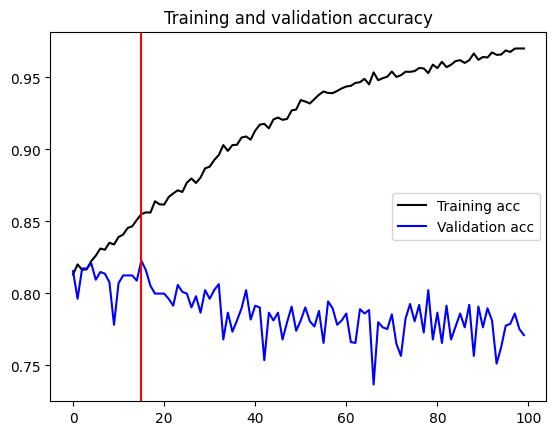

<Figure size 640x480 with 0 Axes>

In [ ]:
history = model.fit(train_ds, epochs=100, validation_data=val_ds)

plotEpoch( history.history ) # val_accuracy: 0.8173